# Libraries & Modules for YAMNet

In [1]:
!pip install tensorflow_io==0.29.0

In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import soundfile as sf

import glob
import json
import re

os.environ["CUDA_VISIBLE_DEVICES"]='0'

"""
import warnings
warnings.filterwarnings('ignore')
"""

2024-02-18 19:48:31.593232: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-18 19:48:31.614782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 19:48:31.614805: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 19:48:31.614827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 19:48:31.619809: I tensorflow/core/platform/cpu_feature_g

"\nimport warnings\nwarnings.filterwarnings('ignore')\n"

# Load pretrained models & samples

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2024-02-18 19:48:34.548605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-18 19:48:34.569788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-18 19:48:34.569965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

./test_data/miaow_16k.wav


In [4]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

2024-02-18 16:28:39.329632: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-02-18 16:28:39.629442: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-02-18 16:28:39.629458: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-02-18 16:28:39.629486: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-18 16:28:39.629669: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-18 16:28:39.629683: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc

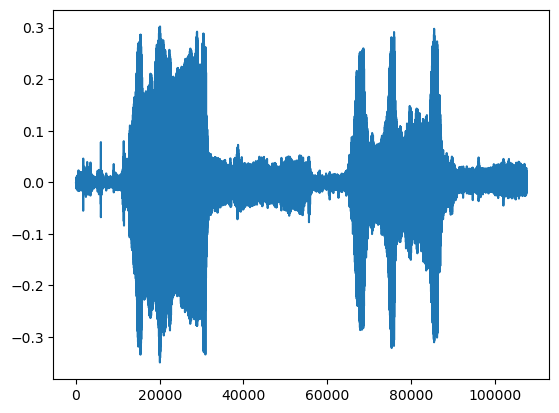

In [6]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

# Load class mappings

In [5]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
Baby cry, infant cry
Whimper
Wail, moan
Sigh
Singing
Choir
Yodeling
Chant
Mantra
Child singing
Synthetic singing
Rapping
Humming
Groan
Grunt
Whistling
Breathing
Wheeze
Snoring
Gasp
Pant
Snort
Cough
Throat clearing
Sneeze
Sniff
Run
Shuffle
Walk, footsteps
Chewing, mastication
Biting
Gargling
Stomach rumble
Burping, eructation
Hiccup
Fart
Hands
Finger snapping
Clapping
Heart sounds, heartbeat
Heart murmur
Cheering
Applause
Chatter
Crowd
Hubbub, speech noise, speech babble
Children playing
Animal
Domestic animals, pets
Dog
Bark
Yip
Howl
Bow-wow
Growling
Whimper (dog)
Cat
Purr
Meow
Hiss
Caterwaul
Livestock, farm animals, working animals
Horse
Clip-clop
Neigh, whinny
Cattle, bovinae
Moo
Cowbell
Pig
Oink
Goat
Bleat
Sheep
Fowl
Chicken, rooster
Cluck
Crowi

In [6]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

NameError: name 'testing_wav_data' is not defined

# Load datasets

In [7]:
"""
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)
"""
!pwd

/data/GDSC_AudioPoli/AudioPoli-AI


In [9]:
base_train_dir = "/data/GDSC_AudioPoli/testset/Training/label/"
base_valid_dir = "/data/GDSC_AudioPoli/testset/Validation/label/"
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'

train_json_files = glob.glob(os.path.join(base_train_dir, '*/*.json'))
valid_json_files = glob.glob(os.path.join(base_valid_dir, '*/*.json'))
train_orig_files = glob.glob(os.path.join(base_train_audio, '*/*.wav'), recursive=True)
valid_orig_files = glob.glob(os.path.join(base_valid_audio, '*/*.wav'), recursive=True)
# valid_orig_files = glob.glob(base_valid_audio + '**/*.wav', recursive=True)

# print(train_json_files, train_orig_files)

def process_json_file(json_file):
    target = re.split('[/._]', json_file)[-2]
    result = [file for file in train_orig_files \
              if "_{0}_".format(target) in file]
    result = result[0] if len(result) > 0 else None
    data = json.load(open(json_file))
    data = pd.json_normalize(data)
    annotations = data['annotations'][0]
    # print(annotations)
    data = []
    for annotation in annotations:
        item = {}
        item['filename'] = result
        item['target'] = target
        item['category'] = annotation['categories']['category_02']
        item['audio_type'] = annotation['audioType']
        data.append(item)

    # print("{0}\n{1}\n".format(json_file, result))
    # print("{0} {1}_{2}".format(target, re.split('[/.\[\]_]', result)[-4], re.split('[/._]', result)[-1]))
    return data


# print(len(training_json_files), len(validation_json_files))
# print(training_json_files[:5], validation_json_files[:5])


all_data = []
"""
for file in train_json_files:
# for file in valid_json_files:
    data = process_json_file(file)
    all_data.extend(data)

# Create a DataFrame from the collected data
df = pd.DataFrame(all_data)

# Write the DataFrame to a CSV file
df.to_csv('output.csv', index=False)
# df.to_csv('output_valid.csv', index=False)
"""

"\nfor file in train_json_files:\n# for file in valid_json_files:\n    data = process_json_file(file)\n    all_data.extend(data)\n\n# Create a DataFrame from the collected data\ndf = pd.DataFrame(all_data)\n\n# Write the DataFrame to a CSV file\ndf.to_csv('output.csv', index=False)\n# df.to_csv('output_valid.csv', index=False)\n"

In [10]:
print(len(all_data))
# df.head()

0


### Experiments (Don't run)

In [11]:
base_train_dir = "/data/GDSC_AudioPoli/testset/Training/label/"
base_valid_dir = "/data/GDSC_AudioPoli/testset/Validation/label/"
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'

train_json_files = glob.glob(os.path.join(base_train_dir, '*/*.json'))
valid_json_files = glob.glob(os.path.join(base_valid_dir, '*/*.json'))
train_orig_files = glob.glob(os.path.join(base_train_audio, '*/*.wav'), recursive=True)
valid_orig_files = glob.glob(os.path.join(base_valid_audio, '*/*.wav'), recursive=True)

json_file = "/data/GDSC_AudioPoli/testset/Validation/label/[라벨]8.전기사고/8.전기사고_236859.json"
target = re.split('[/._]', json_file)[-2]
result = [file for file in valid_orig_files \
          if "_{0}_".format(target) in file][0]
print(target, result)

236859 /data/GDSC_AudioPoli/testset/Validation/orig/[원천]8.전기사고_1/8.전기사고_236859_label.wav


In [ ]:
path = "/data/GDSC_AudioPoli/testset/Training/orig/"
tmp = "/data/GDSC_AudioPoli/testset/Training/label/[라벨]8.전기사고/8.전기사고_226549.json"
foo = "_{0}_".format(re.split('[/._]', tmp)[-2])
print(foo)

train_orig_list = glob.glob(path + '**/*.wav', recursive=True)
print(all_wav_files[:5])

result = [file for file in train_orig_list if foo in file]
print(result)

In [ ]:
path = "/data/GDSC_AudioPoli/testset/Training/orig/"
tmp = "/data/GDSC_AudioPoli/testset/Training/label/[라벨]8.전기사고/8.전기사고_226549.json"
foo = re.split('[/._]', tmp)[-2]
result = [filename for filename in glob.glob("{0}**/*_{1}_label.wav".format(path, foo), recursive=True)][0]
print(foo, result)

### Check

In [8]:
output_csv = '/data/GDSC_AudioPoli/AudioPoli-AI/output.csv'
output_valid_csv = '/data/GDSC_AudioPoli/AudioPoli-AI/output_valid.csv'
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'


pd_data = pd.read_csv(output_csv)
pd_data.head(10)

,filename,target,category,audio_type
0,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,226549,전기사고,voice
1,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,220721,전기사고,voice
2,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,232239,전기사고,voice
3,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234023,전기사고,voice
4,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,222619,전기사고,voice
5,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,168183,전기사고,voice
6,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,1147795,전기사고,voice
7,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,155910,전기사고,voice
8,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,181836,전기사고,voice
9,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234356,전기사고,voice


In [9]:
pd_data

,filename,target,category,audio_type
0,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,226549,전기사고,voice
1,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,220721,전기사고,voice
2,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,232239,전기사고,voice
3,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234023,전기사고,voice
4,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,222619,전기사고,voice
...,...,...,...,...
447060,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,594834,절도범죄,voice
447061,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,1238090,절도범죄,voice
447062,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,1238011,절도범죄,voice
447063,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,595821,절도범죄,voice


### Drop columns with lost filenames

In [ ]:
# pd_data.to_csv('output_dropna.csv', index=False)

# Data Filtering

In [10]:
from sklearn import model_selection

output_dropna_csv = '/data/GDSC_AudioPoli/AudioPoli-AI/output_dropna.csv'
pd_data = pd.read_csv(output_dropna_csv)

my_classes = ['강제추행(성범죄)', '강도범죄', '절도범죄', '폭력범죄',
              '화재', '갇힘', '응급의료', '전기사고', '가스사고', '낙상', 
              '붕괴사고', '태풍-강풍', '지진', '도움요청', '실내', '실외'
             ]
map_class_to_id = {'강제추행(성범죄)':1, '강도범죄':2, '절도범죄':3, '폭력범죄':4,
              '화재':5, '갇힘':6, '응급의료':7, '전기사고':8, '가스사고':9, '낙상':10, 
              '붕괴사고':11, '태풍-강풍':12, '지진':13, '도움요청':14, '실내':15, '실외':16}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(category=class_id)

# KFold (n = 5)
filtered_pd['fold'] = -1
kf = model_selection.StratifiedKFold(n_splits = 16)
for fold, (trn_, val_) in enumerate(kf.split(X=filtered_pd, y=filtered_pd['category'])):
    filtered_pd.loc[val_, 'fold'] = fold

# filtered_pd['Fold'].unique()
    
filtered_pd.head(10)
# filtered_pd['fold'].unique()
# filtered_pd[filtered_pd.fold == 0]

,filename,target,category,audio_type,fold
0,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,226549,8,voice,0
1,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,220721,8,voice,0
2,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,232239,8,voice,0
3,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234023,8,voice,0
4,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,222619,8,voice,0
5,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,168183,8,voice,0
6,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,1147795,8,voice,0
7,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,155910,8,voice,0
8,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,181836,8,voice,0
9,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234356,8,voice,0


# Audio file embeddings

In [11]:
filenames = filtered_pd['filename']
targets = filtered_pd['category']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

2024-02-18 19:49:16.722547: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

# K-Fold


In [14]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 14)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 14)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 15)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Model for embeddings

In [24]:
"""
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
"""

In [ ]:
# Sequential
"""
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')
"""

"""
input_layer = tf.keras.layers.Input(shape=(1024), 
                                    dtype=tf.float32, name='input_embedding')

def resnet_block(input_tensor, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if strides !=  1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters,  1, strides=strides)(input_tensor)
    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    return x

x = resnet_block(input_layer,  64)
x = resnet_block(x,  128, strides=2)
x = resnet_block(x,  256, strides=2)
x = resnet_block(x,  512, strides=2)

output_layer = layers.Dense(len(my_classes))(x)

my_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
"""

In [15]:
from tensorflow.keras import layers, models, regularizers

import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (1024,)

my_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(my_classes))
])

my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [16]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=10,
                       batch_size=1000,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/10


2024-02-18 19:49:39.322258: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-02-18 19:49:39.322275: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-02-18 19:49:39.322315: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-18 19:49:39.371673: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-18 19:49:39.371868: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-18 19:49:39.372198: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191

   1782/Unknown - 74s 39ms/step - loss: 1.1448 - accuracy: 0.9178

In [ ]:
# Check for overfittings

loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

### Check with wav metadata

In [29]:
num_channels = []
file_name = []
for wav_file in filtered_pd['filename']:
    # print(wav_file)
    file = open(wav_file, 'rb')
    l1 = file.readline()
    num_channels.append(l1[20:22])
    file_name.append(wav_file)

In [ ]:
for i in range(len(num_channels)):
    if num_channels[i][8:12] != b'WAVE':
        print('File name : {0}'.format(file_name[i]))
        print('Chunk ID : {0}'.format(num_channels[i][0:4]))
        print('Chunk Size : {0}'.format(num_channels[i][4:8]))
        print('Format : {0}'.format(num_channels[i][8:12]))
        print('Chunk ID : {0}'.format(num_channels[i][12:16]))
        print('Chunk Size : {0}'.format(num_channels[i][16:20]))
        print('Audio Format : {0}'.format(num_channels[i][20:22]))
        print('Channel number : {0}'.format(num_channels[i][22:24]))
        print("----------------------------------------")

In [30]:
from collections import Counter
Counter(num_channels)

Counter({b'\x01\x00': 407516, b'': 34003})

In [31]:
# "/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_501776_label.wav"
# "/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_502855_label.wav"
# "/data/GDSC_AudioPoli/testset/Training/orig/[원천]14.도움요청_1/14.도움요청_757631_label.wav"



tmp = "/data/GDSC_AudioPoli/testset/Training/orig/[원천]8.전기사고_1/8.전기사고_60279_label.wav"
print('File name : {0}'.format(tmp))
foo = open(tmp, 'rb')
bar = foo.readline()
print('Chunk ID : {0}'.format(bar[0:4]))
print('Chunk Size : {0}'.format(bar[4:8]))
print('Format : {0}'.format(bar[8:12]))
print('Chunk ID : {0}'.format(bar[12:16]))
print('Chunk Size : {0}'.format(bar[16:20]))
print('Audio Format : {0}'.format(bar[20:22]))
print('Channel number : {0}'.format(bar[22:24]))
print("----------------------------------------")

File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]8.전기사고_1/8.전기사고_60279_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'\x08\x00\x00\x00'
Format : b'WAVE'
Chunk ID : b'fmt '
Chunk Size : b'\x10\x00\x00\x00'
Audio Format : b'\x01\x00'
Channel number : b'\x02\x00'
----------------------------------------


### Check whether problem due to float32 encoding

In [29]:
# Failed to load
# tmp = load_wav_16k_mono("/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_501776_label.wav")
tmp = "/data/GDSC_AudioPoli/testset/Training/orig/[원천]8.전기사고_1/8.전기사고_60279_label.wav"
file_contents = tf.io.read_file(tmp)
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

# Succeeded to load
# tmp = load_wav_16k_mono("/data/GDSC_AudioPoli/testset/Training/orig/[원천]5.화재_1/5.화재_1033548_label.wav")
# tmp = load_wav_16k_mono("/data/GDSC_AudioPoli/testset/Training/orig/[원천]1.강제추행(성범죄)_1/1.강제추행(성범죄)_1236427_label.wav")
_ = plt.plot(tmp)

# Play the audio file.
display.Audio(tmp, rate=16000)

2024-02-17 15:40:16.262502: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: WAV data chunk '����' is too large: 4293722111 bytes, but the limit is 2147483647


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 107: invalid start byte

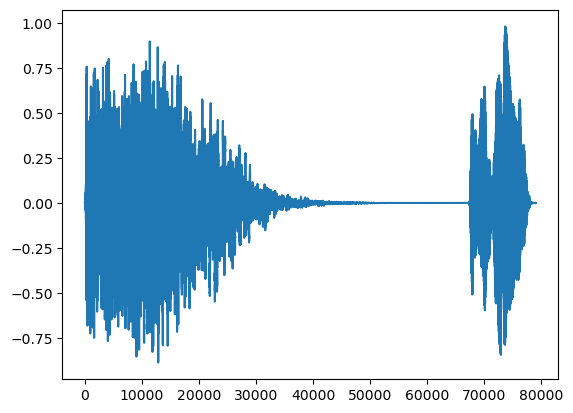

In [142]:
input_file = '/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_501776_label.wav'
output_file = './output.wav'

data, samplerate = sf.read(input_file)
sf.write(output_file, data, samplerate, subtype='PCM_16')


# tmp = load_wav_16k_mono(input_file)
tmp = load_wav_16k_mono(output_file)
_ = plt.plot(tmp)

# Play the audio file.
display.Audio(tmp, rate=16000)

### Convert float32 to int16

In [ ]:
num_channels = []
file_name = []
for wav_file in filtered_pd['filename']:
    try:
        file_contents = tf.io.read_file(wav_file)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    except Exception as e:
        # print(wav_file)
        with sf.SoundFile(wav_file, 'rb') as file:
            data, samplerate = file.read(), file.samplerate
            samplerate = file.samplerate
            channels = file.channels
        with sf.SoundFile(wav_file, 'w', samplerate=samplerate, channels=channels, subtype='PCM_16') as file:
            file.write(data)

### UnicodeDecodeError issue

In [ ]:
num_channels = []
file_name = []
for wav_file in filtered_pd['filename']:
    try:
        file_contents = tf.io.read_file(wav_file)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    except Exception as e:
        print(wav_file)
        """
        with sf.SoundFile(wav_file, 'r') as file:
            data, samplerate = file.read(), file.samplerate
        with sf.SoundFile(wav_file, 'w', samplerate=samplerate, subtype='PCM_16') as file:
            file.write(data)
        """


In [ ]:
num_channels = []
file_name = []
for wav_file in filtered_pd['filename']:
    try:
        file_contents = tf.io.read_file(wav_file)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    except Exception as e:
        print(wav_file)
        with sf.SoundFile(wav_file, 'r') as file:
            data, samplerate = file.read(), file.samplerate
        with sf.SoundFile(wav_file, 'w', samplerate=samplerate, subtype='PCM_16') as file:
            file.write(data)

# Testing model


In [162]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 4]
# print(test_pd)
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
tmp = load_wav_16k_mono(filename)

/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_685047_label.wav


2024-02-17 13:46:59.574695: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 13:46:59.587251: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 13:46:59.587270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 13:46:59.587276: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 13:46:59.587281: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 13:46:59.587288: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 13:46:59.587292: I tens

InvalidArgumentError: Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_435920/1003598801.py", line 6, in <module>

  File "/tmp/ipykernel_435920/2893689446.py", line 7, in load_wav_16k_mono

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_435920/1003598801.py", line 6, in <module>

  File "/tmp/ipykernel_435920/2893689446.py", line 7, in load_wav_16k_mono

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]]
	 [[loop_body/IO>AudioResample/pfor/while/body/_10/loop_body/IO>AudioResample/pfor/while/IO>AudioResample/_28]]
  (1) INVALID_ARGUMENT:  Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_load_wav_16k_mono_54950]

In [93]:
# scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
scores, embeddings, spectrogram = yamnet_model(tmp)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: 낙상


### Pipelines for wave-input model

In [45]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [46]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


In [ ]:
tf.keras.utils.plot_model(serving_model)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')


# Comparison with YAMNet models

/data/GDSC_AudioPoli/testset/Training/orig/[원천]14.도움요청_1/14.도움요청_793062_label.wav


Waveform values: [-1.9250681e-08  5.8154509e-08  8.3268205e-08 ...  5.1474422e-03
  3.3663702e-03  2.6304845e-03]


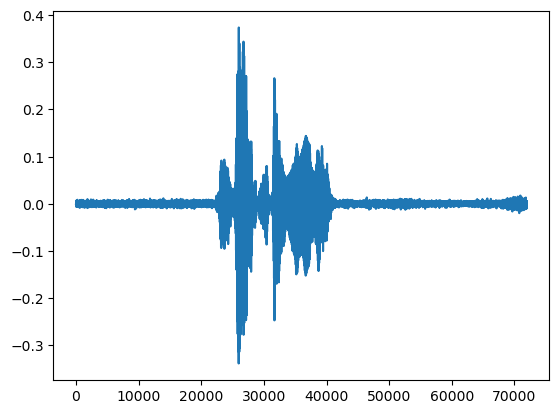

In [54]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 4]
# print(test_pd)
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [55]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

"""
reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')
"""

[YAMNet] The main sound is: Speech (0.43215325474739075)


"\nreloaded_results = reloaded_model(waveform)\nyour_top_class = tf.math.argmax(reloaded_results)\nyour_inferred_class = my_classes[your_top_class]\nclass_probabilities = tf.nn.softmax(reloaded_results, axis=-1)\nyour_top_score = class_probabilities[your_top_class]\nprint(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')\n"